<a href="https://colab.research.google.com/github/pararthdave/ViT-YOLO-Object-Detection/blob/main/ViT_YOLO_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.2 MB/s eta 0:00:00


In [144]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/test-stuff2017/000000000128.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# image.resize((500, 500))

## ViT

### Base Model

In [145]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


Predicted class: Indian elephant, Elephas maximus


### Hybrid Model

In [146]:
from transformers import AutoImageProcessor, ViTHybridForImageClassification
import torch

image_processor = AutoImageProcessor.from_pretrained("google/vit-hybrid-base-bit-384")
model = ViTHybridForImageClassification.from_pretrained("google/vit-hybrid-base-bit-384")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

Indian elephant, Elephas maximus


## YOLO

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Detected elephant with confidence 0.999 at location [111.22, 51.94, 354.32, 494.58]


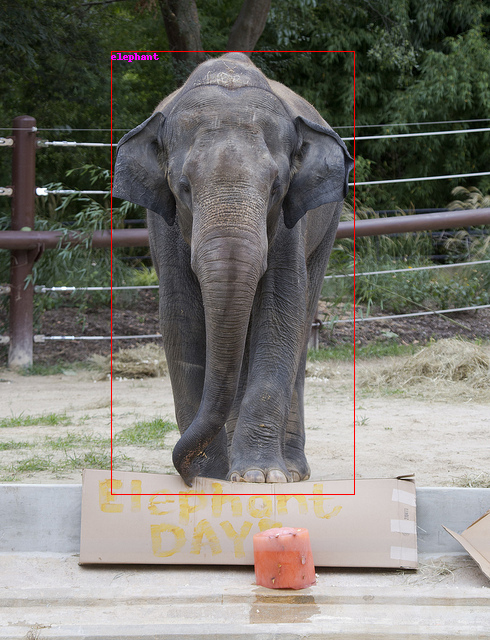

In [147]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from PIL import Image,ImageDraw,ImageFont
import requests

img=image
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")
# font = ImageFont.truetype('/Library/Fonts/Herculanum.ttf', 100)
inputs = image_processor(images=img, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([img.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    xcenter, ycenter, width, height = box
    xmin = xcenter - width / 2
    ymin = ycenter - height / 2
    draw = ImageDraw.Draw(img)
    draw.rectangle([xcenter, ycenter, width, height], outline='red', width=1)
    draw.text((xcenter, ycenter),model.config.id2label[label.item()],(255,0,255))
img.show()